### Run in Google CoLab! (Open in new window or new tab)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/m-wessler/nbm-verify/blob/master/notebooks/verify_1Dqpf_dev.ipynb)

In [44]:
import os
import csv
import urllib.request as req

import scipy.stats as scipy
import numpy as np
import pandas as pd
import xarray as xr

import seaborn as sns
import matplotlib.pyplot as plt

from nbm_funcs import *
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

colors = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#999999"]

***
***
# Configuration
Select 'site' to evaluate, modify 'vsite' if an alternate verification site is preferred<br>
Fixed 'date0' at the start of the NBM v3.2 period (2/20/2020)<br>
Full lead time is 263 hours - Note if date1 is within this period, there will be missing verification data as it does not exist yet!

In [2]:
# NBM 1D Viewer Site to use
site = 'KSEA'
vsite = site

# Data Range
lead_time_end = 263
init_hours = [13]#[1, 7, 13, 19]

date0 = datetime(2020, 2, 20)
date1 = datetime(2020, 7, 8)

In [3]:
sitepath = site if site == vsite else '_'.join([site, vsite])

datadir = '../archive/%s/data/'%sitepath
os.makedirs(datadir, exist_ok=True)

figdir = '../archive//%s/figures/'%sitepath
os.makedirs(figdir, exist_ok=True)

dates = pd.date_range(date0, date1, freq='1D')
date2 = date1 + timedelta(hours=lead_time_end)

print(('\nForecast Site: {}\nVerif Site: {}\nInit Hours: '+
      '{}\nFirst Init: {}\nLast Init: {}\nLast Verif: {}').format(
    site, vsite, init_hours, date0, date1, date2))


Forecast Site: KSEA
Verif Site: KSEA
Init Hours: [1, 7, 13, 19]
First Init: 2020-02-20 00:00:00
Last Init: 2020-07-08 00:00:00
Last Verif: 2020-07-18 23:00:00


***
***
# Obtain observation data from SynopticLabs (MesoWest) API
These are quality-controlled precipitation observations with adjustable accumulation periods<br>
See more at: https://developers.synopticdata.com/mesonet/v2/stations/precipitation/
<br><br>
If no observation file exists, will download and save for future use

In [4]:
obfile = datadir + '%s_obs_%s_%s.pd'%(site, date0.strftime('%Y%m%d'), date1.strftime('%Y%m%d'))

if os.path.isfile(obfile):
    # Load file
    obs = pd.read_pickle(obfile)
    print('\nLoaded obs from file %s\n'%obfile)

else:
    # Get and save file
    obs = get_precip_obs(vsite, date0, date2)
    obs = obs[0].merge(obs[1], how='inner', on='ValidTime').merge(obs[2], how='inner', on='ValidTime')
    obs = obs[[k for k in obs.keys() if 'precip' in k]].sort_index()

    obs.to_pickle(obfile)
    print('\nSaved obs to file %s\n'%obfile)
    
mm_in = 1/25.4
obs *= mm_in
[obs.rename(columns={k:k.replace('mm', 'in')}, inplace=True) for k in obs.keys()]

obs.describe().T

Working: Interval 6h Iteration 1
Working: Interval 12h Iteration 2
Working: Interval 12h Iteration 1
Working: Interval 24h Iteration 4
Working: Interval 24h Iteration 3
Working: Interval 24h Iteration 2
Working: Interval 24h Iteration 1

Saved obs to file ../archive/KSEA/data/KSEA_obs_20200220_20200708.pd



,count,mean,std,min,25%,50%,75%,max
6h_precip_in,580.0,0.018041,0.065351,0.0,0.0,0.0,0.00,0.640000
12h_precip_in,580.0,0.035662,0.105541,0.0,0.0,0.0,0.01,0.780000
24h_precip_in,580.0,0.072906,0.168010,0.0,0.0,0.0,0.05,1.251969


#### Plot the distribution of precipitation observations for assessment

In [5]:
plt.rcParams.update({'font.size': 14})
binsize = 0.05

thresholds = {}
for interval in [6, 12, 24]:
        
    iobs = obs['%dh_precip_in'%interval].values
    iobs[iobs <= 0.01] = np.nan
    
    thresholds[interval] = np.nanpercentile(iobs, (33, 67))

    fig, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='w')
    
    ax.hist(iobs, bins=np.arange(0, np.nanmax(iobs), binsize), 
            edgecolor='k', density=True, color='gray', alpha=0.75,
            label='PDF (%.2f in bins)'%binsize)
    
    axx = ax.twinx()
    axx.hist(iobs, bins=np.arange(0, np.nanmax(iobs), 0.00001), 
            density=True, cumulative=True, histtype='step', edgecolor='k', linewidth=2.5)
    axx.plot(0, linewidth=2.5, color='k', label='CDF (Continuous)')
    
    for p, c in zip([33, 67], ['g', 'r']):
        ax.axvline(np.nanpercentile(iobs, p), color=c, linewidth=3, zorder=-1, 
                   label='%dth Percentile: %.2f in'%(p, np.nanpercentile(iobs, p)))

    ax.set_xticks(np.arange(0, np.nanmax(iobs)+1, binsize))
    ax.set_xticklabels(['%.2f'%v for v in np.arange(0, np.nanmax(iobs)+1, binsize)], rotation=45)
    
    axx.set_ylabel('\nCumulative [%]')
    axx.set_yticks([0, .2, .4, .6, .8, 1.0])
    axx.set_yticklabels([0, 20, 40, 60, 80, 100])
    axx.set_ylim([0, 1.01])
    
    ax.set_xlim([0, np.nanmax(iobs)-0.05])
    
    ax.set_xlabel('\n%dh Observed Accumulated Precipitation [in]'%interval)
    ax.set_ylabel('Frequency [%]\n')
    ax.set_title('%s\n%dh Observed Accumulated Precipitation\nNBM v3.2 Period %s – %s\n'%(
        site, interval, date0.strftime('%Y-%m-%d'), date2.strftime('%Y-%m-%d')))
    
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = axx.get_legend_handles_labels()
    axx.legend(lines + lines2, labels + labels2, loc='center right')

    ax.grid(True)
    plt.tight_layout()
    
    savestr = '{}_{}h.observedAPCP.png'.format(site, interval)
    print(savestr)
    
    os.makedirs(figdir + 'apcp_dist/', exist_ok=True)
    plt.savefig(figdir + 'apcp_dist/' + savestr, dpi=150)
    
    plt.close()
    # plt.show()

KSEA_6h.observedAPCP.png
KSEA_12h.observedAPCP.png
KSEA_24h.observedAPCP.png


***
***
# Obtain NBM forecast data from NBM 1D Viewer (csv file API)
These are the NBM 1D output files extracted from the viewer with 3 set accumulation periods<br>
See more at: https://hwp-viz.gsd.esrl.noaa.gov/wave1d/?location=KSLC&col=2&hgt=1&obs=true&fontsize=1&selectedgroup=Default
<br><br>
If no forecast file exists, will download and save for future use. This can take some time.

In [6]:
nbmfile = datadir + '%s_nbm_%s_%s.pd'%(site, date0.strftime('%Y%m%d'), date1.strftime('%Y%m%d'))

if os.path.isfile(nbmfile):
    # Load file
    nbm = pd.read_pickle(nbmfile)
    print('Loaded NBM from file %s'%nbmfile)

else:
    url_list = []
    for date in dates:
        for init_hour in init_hours:
            # For now pull from the csv generator
            # Best to get API access or store locally later
            base = 'https://hwp-viz.gsd.esrl.noaa.gov/wave1d/data/archive/'
            datestr = '{:04d}/{:02d}/{:02d}'.format(date.year, date.month, date.day)
            sitestr = '/NBM/{:02d}/{:s}.csv'.format(init_hour, site)
            url_list.append([date, init_hour, base + datestr + sitestr])

    # Try multiprocessing this for speed?
    nbm = np.array([get_1d_csv(url, this=i+1, total=len(url_list)) for i, url in enumerate(url_list)])
    nbm = np.array([line for line in nbm if line is not None])

    header = nbm[0, 0]
    
    # This drops days with incomplete collections. There may be some use
    # to keeping this data, can fix in the future if need be
    # May also want to make the 100 value flexible!
    nbm = np.array([np.array(line[1]) for line in nbm if len(line[1]) == 100])

    nbm = nbm.reshape(-1, nbm.shape[-1])
    nbm[np.where(nbm == '')] = np.nan

    # Aggregate to a clean dataframe
    nbm = pd.DataFrame(nbm, columns=header).set_index(
        ['InitTime', 'ValidTime']).sort_index()

    # Drop last column (misc metadata?)
    nbm = nbm.iloc[:, :-2].astype(float)
    header = nbm.columns

    # variables = np.unique([k.split('_')[0] for k in header])
    # levels = np.unique([k.split('_')[1] for k in header])

    init =  nbm.index.get_level_values(0)
    valid = nbm.index.get_level_values(1)

    # Note the 1h 'fudge factor' in the lead time here
    lead = pd.DataFrame(
        np.transpose([init, valid, ((valid - init).values/3600/1e9).astype(int)+1]), 
        columns=['InitTime', 'ValidTime', 'LeadTime']).set_index(['InitTime', 'ValidTime'])

    nbm.insert(0, 'LeadTime', lead)

    klist = np.array([k for k in np.unique([k for k in list(nbm.keys())]) if ('APCP' in k)&('1hr' not in k)])
    klist = klist[np.argsort(klist)]
    klist = np.append('LeadTime', klist)
    nbm = nbm.loc[:, klist]
    
    # Nix values where lead time shorter than acc interval
    for k in nbm.keys():
        if 'APCP24hr' in k:
            nbm[k][nbm['LeadTime'] < 24] = np.nan
        elif 'APCP12hr' in k:
            nbm[k][nbm['LeadTime'] < 12] = np.nan
        elif 'APCP6hr' in k:
            nbm[k][nbm['LeadTime'] < 6] = np.nan
        else:
            pass
    
    nbm.to_pickle(nbmfile)
    print('\nSaved NBM to file %s'%obfile)

# Convert mm to in
nbm = pd.DataFrame([nbm['LeadTime']] + [nbm[k] * mm_in for k in nbm.keys() if 'LeadTime' not in k]).T

# Display some basic stats
nbm.loc[:, ['APCP6hr_surface', 'APCP6hr_surface_70% level', 'APCP6hr_surface_50% level',
            'APCP12hr_surface', 'APCP12hr_surface_70% level', 'APCP12hr_surface_50% level',
            'APCP24hr_surface', 'APCP24hr_surface_70% level', 'APCP24hr_surface_50% level'
            ]].describe().T

[560/560] 2020-07-08 00:00:00 190:00:00 13
Saved NBM to file ../archive/KSEA/data/KSEA_obs_20200220_20200708.pd


,count,mean,std,min,25%,50%,75%,max
APCP6hr_surface,21062.0,0.014014,0.037579,0.0,0.0,0.000000,0.000000,0.550000
APCP6hr_surface_70% level,21472.0,0.014956,0.037770,0.0,0.0,0.000000,0.008307,0.424961
APCP6hr_surface_50% level,21472.0,0.004676,0.020427,0.0,0.0,0.000000,0.000000,0.342520
APCP12hr_surface,20984.0,0.035931,0.075421,0.0,0.0,0.000000,0.033553,0.686614
APCP12hr_surface_70% level,20984.0,0.037218,0.070633,0.0,0.0,0.000827,0.044656,0.676181
APCP12hr_surface_50% level,20984.0,0.013878,0.040987,0.0,0.0,0.000000,0.001654,0.490551
APCP24hr_surface,9736.0,0.075651,0.127154,0.0,0.0,0.004587,0.104469,0.806142
APCP24hr_surface_70% level,9736.0,0.091582,0.127745,0.0,0.0,0.033071,0.141663,0.818543
APCP24hr_surface_50% level,9736.0,0.044920,0.085533,0.0,0.0,0.000354,0.052224,0.630118


#### Plot the distribution of precipitation forecasts for assessment

In [9]:
plt.rcParams.update({'font.size': 14})
binsize = 0.05

thresholds = {}
for interval in [6, 12, 24]:
        
    iobs = nbm['APCP%dhr_surface'%interval].values
    iobs[iobs <= 0.01] = np.nan
    
    thresholds[interval] = np.nanpercentile(iobs, (33, 67))

    fig, ax = plt.subplots(1, 1, figsize=(10, 6), facecolor='w')
    
    ax.hist(iobs, bins=np.arange(0, np.nanmax(iobs), binsize), 
            edgecolor='k', density=True, color='gray', alpha=0.75,
            label='PDF (%.2f in bins)'%binsize)
    
    axx = ax.twinx()
    axx.hist(iobs, bins=np.arange(0, np.nanmax(iobs), 0.00001), 
            density=True, cumulative=True, histtype='step', edgecolor='k', linewidth=2.5)
    axx.plot(0, linewidth=2.5, color='k', label='CDF (Continuous)')
    
    for p, c in zip([33, 67], ['g', 'r']):
        ax.axvline(np.nanpercentile(iobs, p), color=c, linewidth=3, zorder=-1, 
                   label='%dth Percentile: %.2f in'%(p, np.nanpercentile(iobs, p)))

    ax.set_xticks(np.arange(0, np.nanmax(iobs)+1, binsize))
    ax.set_xticklabels(['%.2f'%v for v in np.arange(0, np.nanmax(iobs)+1, binsize)], rotation=45)
    
    axx.set_ylabel('\nCumulative [%]')
    axx.set_yticks([0, .2, .4, .6, .8, 1.0])
    axx.set_yticklabels([0, 20, 40, 60, 80, 100])
    axx.set_ylim([0, 1.01])
    
    ax.set_xlim([0, np.nanmax(iobs)-0.05])
    
    ax.set_xlabel('\n%dh Forecast Precipitation [in]'%interval)
    ax.set_ylabel('Frequency [%]\n')
    ax.set_title('%s\n%dh Forecast Precipitation\nNBM v3.2 Period %s – %s\n'%(
        site, interval, date0.strftime('%Y-%m-%d'), date2.strftime('%Y-%m-%d')))
    
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = axx.get_legend_handles_labels()
    axx.legend(lines + lines2, labels + labels2, loc='center right')
    
    ax.grid(True)
    plt.tight_layout()
    
    savestr = '{}_{}h.detForecastAPCP.png'.format(site, interval)
    print(savestr)
    
    os.makedirs(figdir + 'apcp_dist/', exist_ok=True)
    plt.savefig(figdir + 'apcp_dist/' + savestr, dpi=150)
    
    plt.close()
    # plt.show()

KSEA_6h.detForecastAPCP.png
KSEA_12h.detForecastAPCP.png
KSEA_24h.detForecastAPCP.png


In [93]:
plt.rcParams.update({'font.size': 12})
binsize = 0.05

thresholds = {}
for interval in [6, 12, 24]:
        
    iobs = obs['%dh_precip_in'%interval]
    iobs[iobs <= 0.01] = np.nan
    
    ifx = nbm['APCP%dhr_surface'%interval]
    ifx[ifx <= 0.01] = np.nan
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 6), facecolor='w')
    ax, axx = axs
    
    maxval = max(np.nanmax(iobs), np.nanmax(iobs))
    
    ax.hist(iobs, bins=np.arange(0, maxval, binsize), 
            edgecolor='k', density=True, color=colors[0], alpha=0.75,
            label='Observed PDF (%.2f in bins)'%binsize)
    
    ax.hist(ifx, bins=np.arange(0, maxval, binsize), 
        edgecolor='k', density=True, color=colors[1], alpha=0.75,
        label='Forecast PDF (%.2f in bins)'%binsize)
    
    axx.hist(iobs, bins=np.arange(0, maxval, 0.00001), 
            density=True, cumulative=True, histtype='step', 
            linewidth=2.5, edgecolor=colors[0])
    axx.plot(0, linewidth=2.5, color=colors[0], label='Observed CDF (Continuous)')
    
    axx.hist(ifx, bins=np.arange(0, maxval, 0.00001), 
            density=True, cumulative=True, histtype='step', 
            linewidth=2.5, linestyle='-', edgecolor=colors[1])
    axx.plot(0, linewidth=2.5, linestyle='-', color=colors[1], label='Forecast CDF (Continuous)')
    
    for p, c in zip([33, 67], [colors[4], colors[5]]):
        ax.axvline(np.nanpercentile(iobs, p), color=c, linewidth=3, zorder=100, 
                   label='%dth Percentile Obs: %.2f in'%(p, np.nanpercentile(iobs, p)))
    
    axx.set_ylabel('\nCumulative [%]')
    axx.set_yticks([0, .2, .4, .6, .8, 1.0])
    axx.set_yticklabels([0, 20, 40, 60, 80, 100])
    axx.set_ylim([0, 1.01])
        
    for axi in axs:
        axi.set_xticks(np.arange(0, maxval+binsize, binsize*2))
        axi.set_xticklabels(['%.2f'%v for v in np.arange(0, maxval+binsize, binsize*2)], rotation=45)
        axi.set_xlim([0, maxval-binsize])
        axi.set_xlabel('\n%dh Forecast Precipitation [in]'%interval)
        
        axi.set_ylabel('Frequency [%]\n')
        
        axi.set_title('%s\n%dh Forecast Precipitation\nNBM v3.2 Period %s – %s\n'%(
            site, interval, date0.strftime('%Y-%m-%d'), date2.strftime('%Y-%m-%d')))
        
        axi.grid(True)
        
    ax.legend(loc='upper right')
    axx.legend(loc='lower right')
  
    plt.tight_layout()
    
    savestr = '{}_{}h.APCP_dist.png'.format(site, interval)
    print(savestr)
    
    os.makedirs(figdir + 'apcp_dist/', exist_ok=True)
    plt.savefig(figdir + 'apcp_dist/' + savestr, dpi=150)
    
    plt.close()
    plt.show()

KSEA_6h.APCP_dist.png
KSEA_12h.APCP_dist.png
KSEA_24h.APCP_dist.png


***
***
# Reorganize the data for analysis:
#### Isolate the forecasts by accumulation interval and lead time

In [94]:
# Event size thresholds 
# Use fixed override if desired else 
# 33rd, 67th percentile determined above
thresholds = {
    6:[.1, .25],
    12:[.25, .5],
    24:[.5, .75]}

threshold_sets = [
    [0, thresholds[interval][0]], 
    [thresholds[interval][0], thresholds[interval][1]], 
    [thresholds[interval][1], np.ceil(np.nanmax(obs))],
    [np.nan, np.nan]]

plist = np.arange(1, 100)

data = []
for interval in [6, 12, 24]:
    
    pkeys = np.array([k for k in nbm.keys() if '%dhr_'%interval in k])
    pkeys = np.array([k for k in pkeys if '%' in k])
    pkeys = pkeys[np.argsort([int(k.split('_')[-1].split('%')[0]) for k in pkeys])]
    
    for lead_time in np.arange(interval, lead_time_end, 6):
        
        for thresh, esize in zip(threshold_sets, ['Small', 'Medium', 'Large']):
        
            print('\rProcessing interval %d lead %dh'%(interval, lead_time), end='')

            # We need to break out the verification to each lead time,
            # but within each lead time we have a number of valid times.
            # At each lead time, valid time, isolate the forecast verification

            # Combine the datasets to make it easier to work with
            idata = nbm[nbm['LeadTime'] == lead_time].merge(obs, on='ValidTime').drop(columns='LeadTime')

            # Subset for event size
            iobs = idata['%dh_precip_in'%interval]
            idata = idata[((iobs >= thresh[0]) & (iobs < thresh[1]))]
                
            for itime in idata.index:

                try:
                    prob_fx = idata.loc[itime, pkeys].values
                    mean_fx = np.nanmean(prob_fx)
                    std_fx = np.nanstd(prob_fx)
                    med_fx = idata.loc[itime, 'APCP%dhr_surface_50%% level'%interval]
                    det_fx = idata.loc[itime, 'APCP%dhr_surface'%interval]

                    # Optional - leave as nan?
                    det_fx = det_fx if ~np.isnan(det_fx) else 0.

                    verif_ob = idata.loc[itime, '%dh_precip_in'%interval]
                    verif_rank = np.searchsorted(prob_fx, verif_ob, 'right')
                    verif_rank_val = prob_fx[verif_rank-1]
                    verif_rank_error = verif_rank_val - verif_ob

                    det_rank = np.searchsorted(prob_fx, det_fx, 'right')
                    det_error = det_fx - verif_ob

                except:
                    pass
                    # print('failed', itime)

                else:
                    if ((verif_ob > 0.)):

                        data.append([
                            # Indexers
                            interval, lead_time, itime, esize,

                            # Verification and deterministic
                            verif_ob, det_fx, det_rank, det_error,

                            # Probabilistic
                            verif_rank, verif_rank_val, verif_rank_error, 
                            med_fx, mean_fx, std_fx])

data = pd.DataFrame(data, columns=['Interval', 'LeadTime', 'ValidTime', 'EventSize',
                'verif_ob', 'det_fx', 'det_rank', 'det_error',
                'verif_rank', 'verif_rank_val', 'verif_rank_error', 
                'med_fx', 'mean_fx', 'std_fx'])

print('\n\nAvailable keys:\n\t\t{}\nn rows: {}'.format('\n\t\t'.join(data.keys()), len(data)))

Processing interval 24 lead 258h

Available keys:
		Interval
		LeadTime
		ValidTime
		EventSize
		verif_ob
		det_fx
		det_rank
		det_error
		verif_rank
		verif_rank_val
		verif_rank_error
		med_fx
		mean_fx
		std_fx
n rows: 14815


In [95]:
data

,Interval,LeadTime,ValidTime,EventSize,verif_ob,det_fx,det_rank,det_error,verif_rank,verif_rank_val,verif_rank_error,med_fx,mean_fx,std_fx
0,6,6,2020-02-29 06:00:00,Small,0.090000,0.110394,60,0.020394,50,0.089606,-0.000394,0.089606,0.091095,0.061968
1,6,6,2020-02-29 12:00:00,Small,0.030000,0.012441,43,-0.017559,54,0.029882,-0.000118,0.021969,0.041147,0.046711
2,6,6,2020-03-01 06:00:00,Small,0.090000,0.031142,81,-0.058858,96,0.088504,-0.001496,0.000394,0.015208,0.027523
3,6,6,2020-03-03 18:00:00,Small,0.050000,0.000000,54,-0.050000,98,0.033740,-0.016260,0.000000,0.003588,0.009670
4,6,6,2020-03-06 18:00:00,Small,0.180000,0.079094,74,-0.100906,96,0.176260,-0.003740,0.037323,0.052170,0.053932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14810,24,258,2020-04-23 12:00:00,Large,0.770000,0.000000,0,-0.770000,0,NaN,NaN,NaN,NaN,NaN
14811,24,258,2020-05-31 06:00:00,Large,1.070984,0.000000,0,-1.070984,0,NaN,NaN,NaN,NaN,NaN
14812,24,258,2020-05-31 12:00:00,Large,1.251969,0.000000,0,-1.251969,0,NaN,NaN,NaN,NaN,NaN
14813,24,258,2020-05-31 18:00:00,Large,0.983937,0.000000,0,-0.983937,0,NaN,NaN,NaN,NaN,NaN


***
***
# Create Bulk Temporal Stats Plots
#### Reliability diagrams, bias over time, rank over time, etc.

#### Use a pairplot for a basic overview of how certain metrics are correlated

In [97]:
for interval in [6, 12, 24]:
    
    for short, long in zip([0, 120], [120, 240]):
        
        for plot_type, plot_var in zip(
            ['Verification', 'Comparison'], 
            ['verif_rank', 'det_rank']):
            
            for ei, esize in enumerate(['Small', 'Medium', 'Large', 'All']):

                select = data[((data['Interval'] == interval)
                            & ((data['LeadTime'] >= short) 
                            & (data['LeadTime'] <= long)))]

                select = select[select['EventSize'] == esize] if esize != 'All' else select

                try:
                    pairplot = sns.pairplot(select, dropna=True, corner=True,
                                vars=['verif_rank', 'verif_rank_val', 'verif_rank_error', 
                                      'det_fx', 'med_fx', 'mean_fx',  'LeadTime', 'verif_ob'])
                except:
                    pass
                
                else:
                    savestr = '{}_{}h_sz{}_lead{}-{}h.pairplot.{}.png'.format(site, interval, esize, short, long, plot_type.lower())
                    print(savestr)

                    os.makedirs(figdir + 'pairplot/', exist_ok=True)
                    plt.savefig(figdir + 'pairplot/' + savestr)
                    
                    plt.close()
                    # plt.show()

#### Plot a reliability diagram style CDF to evaluate percentile rankings

KSEA_12h_szAll_lead0-120h.reliabilityCDF.verification.png


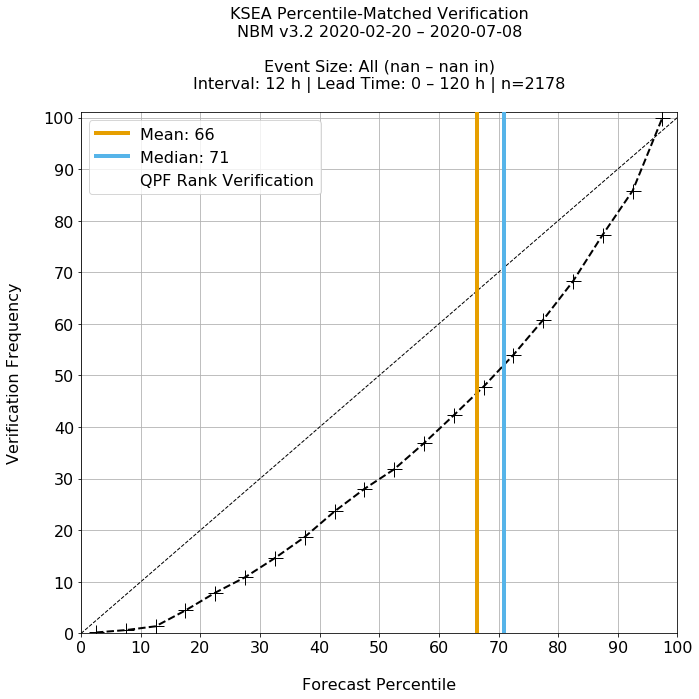

In [175]:
interval = 12
short, long = 0, 120
plot_type = 'Verification'
plot_var = 'verif_rank'
ei, esize = 3, 'All'

select = data[((data['Interval'] == interval)
            & ((data['LeadTime'] >= short) 
            & (data['LeadTime'] <= long)))]

select = select[select['EventSize'] == esize] if esize != 'All' else select

# Produce the actual reliability diagram
font_size = 16
plt.rcParams.update({'font.size': font_size})
fig, ax = plt.subplots(1, figsize=(10, 10), facecolor='w')

pbinsize = 5
pbins = np.arange(0, 101, pbinsize)

hist = ax.hist(select[plot_var], bins=pbins, density=True, cumulative=True,
        color='w', alpha=0, linewidth=3.5, zorder=10, label='QPF Rank %s'%plot_type)
histy, histx = hist[0], hist[1][1:]-(pbinsize/2)

ax.plot(histx, histy, marker='+', linestyle='--', markersize=15, color='k', linewidth=2)

ax.plot(np.arange(0, 101, 1), np.arange(0, 1.01, .01), '--k', linewidth=1, zorder=20)

try:
    ax.axvline(np.nanmean(select[plot_var]), color=colors[0], linewidth=4, 
               zorder=200, label='Mean: %d'%np.nanmean(select[plot_var]))

    ax.axvline(np.nanpercentile(select[plot_var], 50), color=colors[1], linewidth=4, 
               zorder=200, label='Median: %d'%np.nanpercentile(select[plot_var], 50))
except:
    pass

ax.set_xticks(np.arange(0, 101, 10))
ax.set_xlim([0, 100])
ax.set_xlabel('\nForecast Percentile')

ax.set_yticks(np.arange(0, 1.01, .1))
ax.set_yticklabels(np.arange(0, 101, 10))
ax.set_ylim([0, 1.01])
ax.set_ylabel('%s Frequency\n'%plot_type)

ax.set_title(('{} Percentile-Matched {}\nNBM v3.2 {} – {}\n\nEvent Size: {} ({} – {} in)\n'+
              'Interval: {} h | Lead Time: {} – {} h | n={}\n').format(
            site, plot_type, date0.strftime('%Y-%m-%d'), date1.strftime('%Y-%m-%d'),
            esize, threshold_sets[ei][0], threshold_sets[ei][1],
            interval, short, long, len(select)), size=font_size)

ax.legend(loc='upper left')
ax.grid()
plt.tight_layout()

savestr = '{}_{}h_sz{}_lead{}-{}h.reliabilityCDF.{}.png'.format(site, interval, esize, short, long, plot_type.lower())
print(savestr)

os.makedirs(figdir + 'reliabilityCDF/', exist_ok=True)
plt.savefig(figdir + 'reliabilityCDF/' + savestr, dpi=150)

# plt.close()
plt.show()

KSEA_6h_szSmall_lead0-120h.reliabilityCDF.verification.png


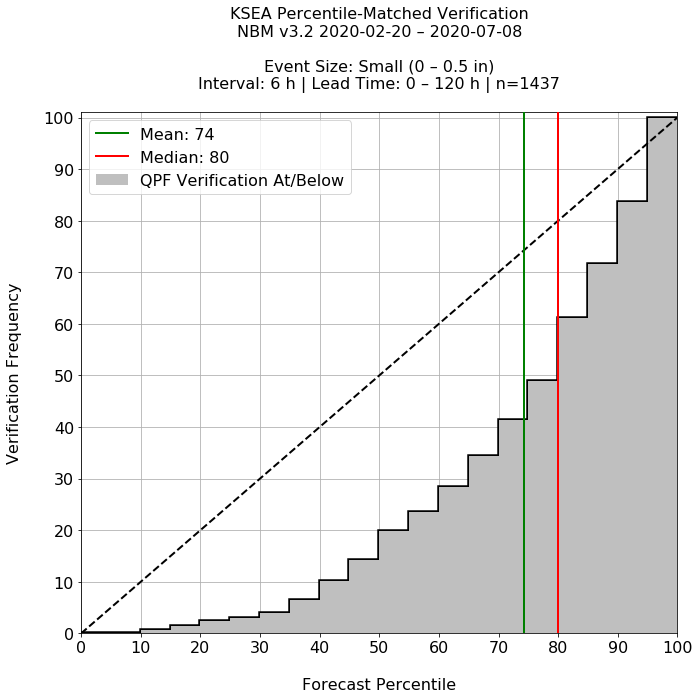

KSEA_6h_szMedium_lead0-120h.reliabilityCDF.verification.png


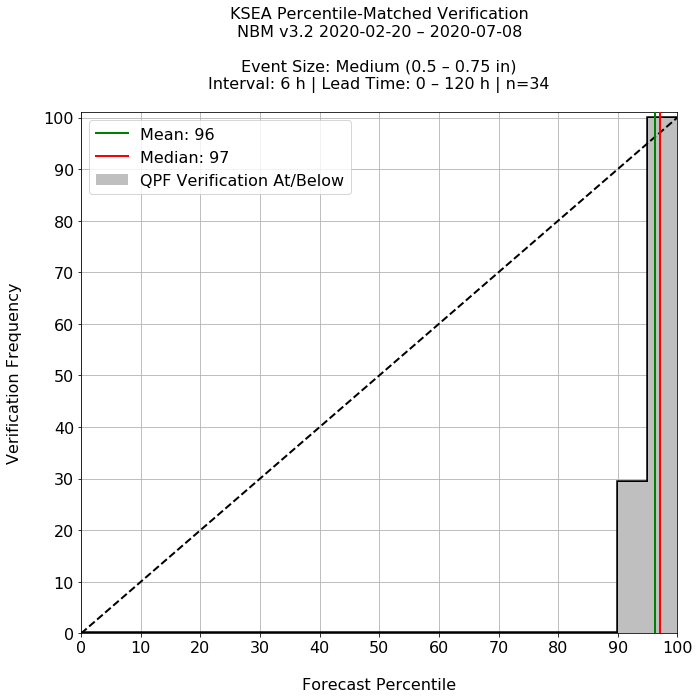

KSEA_6h_szLarge_lead0-120h.reliabilityCDF.verification.png


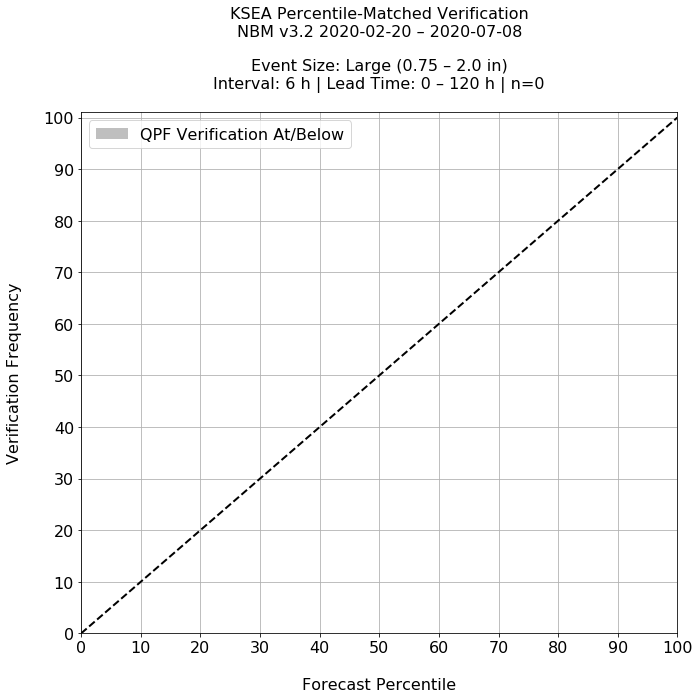

KSEA_6h_szAll_lead0-120h.reliabilityCDF.verification.png


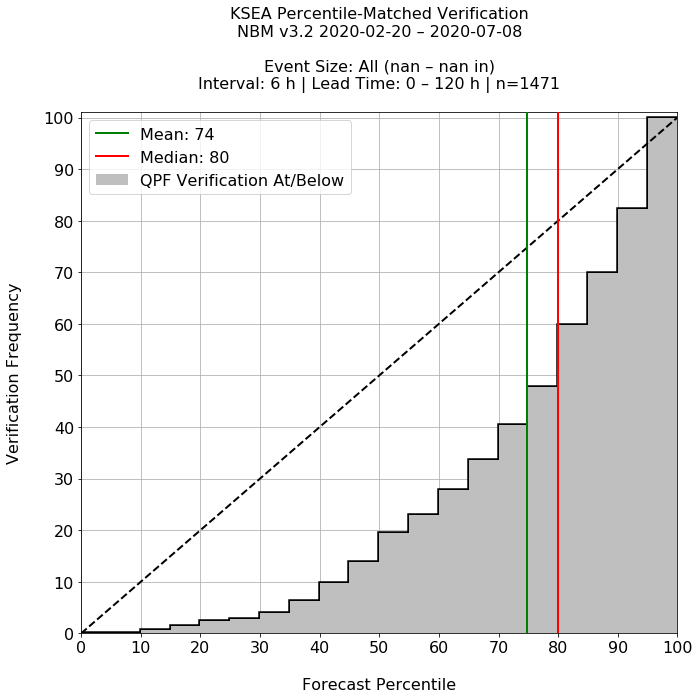

KSEA_6h_szSmall_lead0-120h.reliabilityCDF.comparison.png


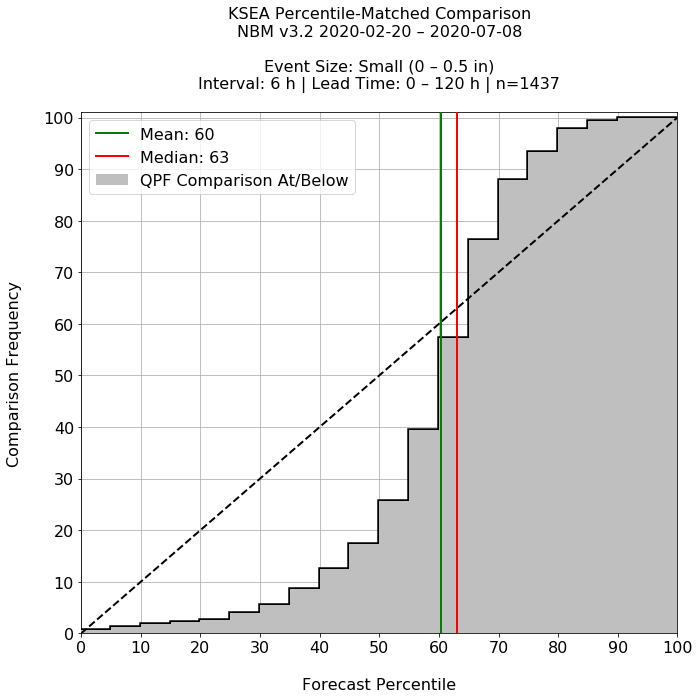

KSEA_6h_szMedium_lead0-120h.reliabilityCDF.comparison.png


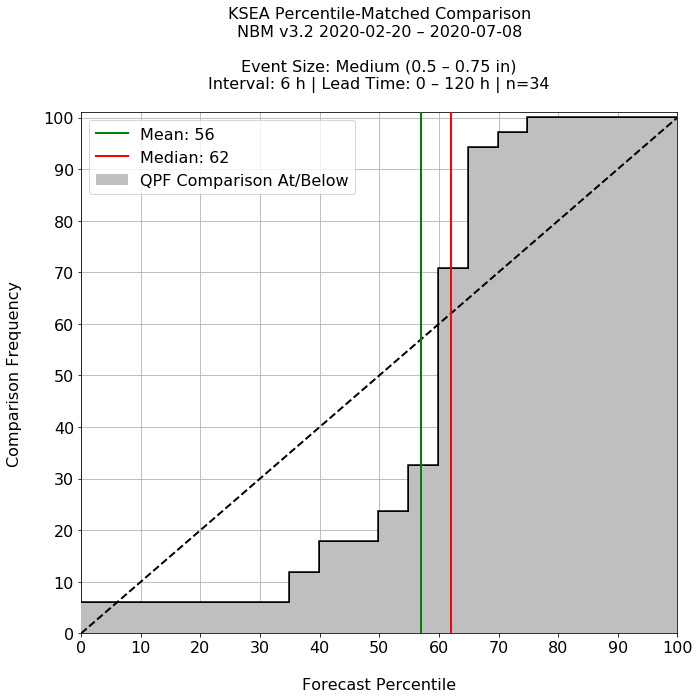

KSEA_6h_szLarge_lead0-120h.reliabilityCDF.comparison.png


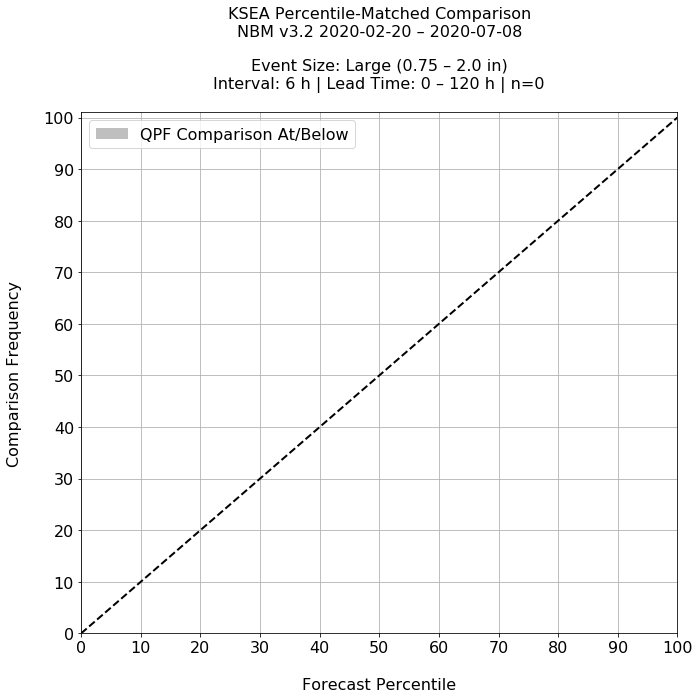

KeyboardInterrupt: 

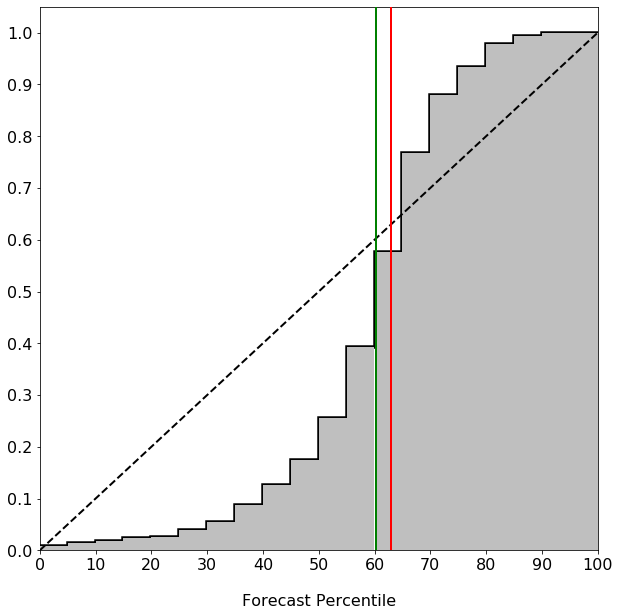

In [103]:
for interval in [6, 12, 24]:

    for short, long in zip([0, 120], [120, 240]):

        for plot_type, plot_var in zip(
            ['Verification', 'Comparison'], 
            ['verif_rank', 'det_rank']):

            for ei, esize in enumerate(['Small', 'Medium', 'Large', 'All']):
                
                select = data[((data['Interval'] == interval)
                            & ((data['LeadTime'] >= short) 
                            & (data['LeadTime'] <= long)))]
                
                select = select[select['EventSize'] == esize] if esize != 'All' else select

                # Produce the actual reliability diagram
                font_size = 16
                plt.rcParams.update({'font.size': font_size})
                fig, ax = plt.subplots(1, figsize=(10, 10), facecolor='w')

                pbins = np.arange(0, 101, 5)

                ax.hist(select[plot_var], bins=pbins, density=True, cumulative=True, histtype='step',
                        color='k', edgecolor='k', linewidth=3.5, zorder=10)

                ax.hist(select[plot_var], bins=pbins, density=True, cumulative=True,
                        color='0.75', linewidth=3.5, zorder=10, label='QPF %s At/Below'%plot_type)

                ax.plot(np.arange(0, 101, 1), np.arange(0, 1.01, .01), '--k', linewidth=2, zorder=20)

                try:
                    ax.axvline(np.nanmean(select[plot_var]), color='g', linewidth=2, 
                               zorder=200, label='Mean: %d'%np.nanmean(select[plot_var]))

                    ax.axvline(np.nanpercentile(select[plot_var], 50), color='r', linewidth=2, 
                               zorder=200, label='Median: %d'%np.nanpercentile(select[plot_var], 50))
                except:
                    pass

                ax.set_xticks(np.arange(0, 101, 10))
                ax.set_xlim([0, 100])
                ax.set_xlabel('\nForecast Percentile')

                ax.set_yticks(np.arange(0, 1.01, .1))
                ax.set_yticklabels(np.arange(0, 101, 10))
                ax.set_ylim([0, 1.01])
                ax.set_ylabel('%s Frequency\n'%plot_type)

                ax.set_title(('{} Percentile-Matched {}\nNBM v3.2 {} – {}\n\nEvent Size: {} ({} – {} in)\n'+
                              'Interval: {} h | Lead Time: {} – {} h | n={}\n').format(
                            site, plot_type, date0.strftime('%Y-%m-%d'), date1.strftime('%Y-%m-%d'),
                            esize, threshold_sets[ei][0], threshold_sets[ei][1],
                            interval, short, long, len(select)), size=font_size)

                ax.legend(loc='upper left')
                ax.grid()
                plt.tight_layout()

                savestr = '{}_{}h_sz{}_lead{}-{}h.reliabilityCDF.{}.png'.format(site, interval, esize, short, long, plot_type.lower())
                print(savestr)

                os.makedirs(figdir + 'reliabilityCDF/', exist_ok=True)
                plt.savefig(figdir + 'reliabilityCDF/' + savestr, dpi=150)
                
                # plt.close()
                plt.show()

#### Produce a true reliability diagram along with error histogram

In [ ]:
for interval in [6, 12, 24]:

    for short, long in zip([0, 120], [120, 240]):

        for plot_type, plot_var in zip(
            ['Deterministic', 'Median', 'Mean'],
            ['det_fx', 'med_fx', 'mean_fx']):

            for ei, esize in enumerate(['Small', 'Medium', 'Large', 'All']):
                esize = None if esize == 'All' else esize

                select = data[((data['Interval'] == interval)
                            & ((data['LeadTime'] >= short) 
                            & (data['LeadTime'] <= long)))]
                
                select = select[select['EventSize'] == esize] if esize != 'All' else select

                try:
                    max_val = max(np.nanmax(select['verif_ob']), np.nanmax(select[plot_var]))
                    max_val = np.ceil(max_val*10)/10
                    max_val = max_val if max_val >= threshold_sets[ei][1] else threshold_sets[ei][1]
                
                except:
                    pass
                
                else:
                    # Produce the actual reliability diagram
                    font_size = 16
                    plt.rcParams.update({'font.size': font_size})

                    fig, axs = plt.subplots(1, 2, figsize=(20, 10), facecolor='w')

                    ax = axs[0]                

                    ax.scatter(select['verif_ob'], select[plot_var], c='k', s=150, marker='+', linewidth=0.5, 
                               label='Forecasts')

                    ax.plot(np.arange(0, max_val+.1, .1), np.arange(0, max_val+.1, .1), '--', label='Perfect Forecast')

                    
                    ax.set_xlim([0, max_val])
                    ax.set_xlabel('\nObserved QPF')

                    ax.set_ylim([0, max_val])
                    ax.set_ylabel('Forecast QPF\n')

                    ax = axs[1]

                    ax.hist(select[plot_var] - select['verif_ob'], bins=np.arange(-0.5, .51, .05), density=True,
                            color='0.45', edgecolor='k', linewidth=1, zorder=10, label='Forecast Error')

                    ax.axvline(0, c='C0', linestyle='--', linewidth=2.5, zorder=10)
                    
                    ax.set_xlabel('Forecast Error')
                    ax.set_ylabel('Error Frequency [% of Forecasts]')

                    for ax in axs:
                        ax.legend(loc='upper left')
                        ax.grid()

                    plt.suptitle(('{} {} Verification\nNBM v3.2 {} – {}\n\nEvent Size: {} ({} – {} in)\n'+
                                  'Interval: {} h | Lead Time: {} – {} h | n={}\n').format(
                                site, plot_type, date0.strftime('%Y-%m-%d'), date1.strftime('%Y-%m-%d'),
                                esize, threshold_sets[ei][0], threshold_sets[ei][1],
                                interval, short, long, len(select)), size=font_size)

                    plt.tight_layout(rect=[0, 0.03, 1, 0.87])

                    savestr = '{}_{}h_sz{}_lead{}-{}h.reliability_errhist.{}.png'.format(site, interval, esize, short, long, plot_type.lower())
                    print(savestr)
                    
                    os.makedirs(figdir + 'reliability_errhist/', exist_ok=True)
                    plt.savefig(figdir + 'reliability_errhist/' + savestr, dpi=150)
                    
                    plt.close()
                    # plt.show()

#### Produce bias, ME, MAE, and percentile rank plots as they evolve over time
This helps illustrate at what leads a dry/wet bias may exist and how severe it may be<br>
Adds value in interpreting the CDF reliability diagrams

## 